In this notebook, we are interpolating between sounds in the "z" domain - the space of the continuous latent space. The sounds are represented as a time series of latent vectors, to that means we are interpolating between different points in latent space at each point in time.  

The results of this kind of interpolation in the latent space of the codec are not particularly interesting, and sound more like a cross fade (except for the amplitude variation which interpolates between the envelopes of the two sounds at each frame).  

Still, it is interesting to see that the quantized space of the codec ( with (1024^9)^100 = 1024^900 = 10^1.8k is dense enough to handle this range of sounds and mixes with such ghigh fidelity. 

In [1]:
%pwd
%cd /app

import dac
from audiotools import AudioSignal

import torch

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.display as ipd

/app


In [2]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory/1e9
torch.cuda.get_device_properties(1).total_memory/1e9
device = torch.device("cuda:0") # if the docker was started with --gpus all, then can choose here.
device

device(type='cuda', index=0)

In [3]:
model_path = dac.utils.download(model_type="44khz") 

### This model doesn't sound as good - because it was trained on different data???
#model_path = "/scratch/codecs/codec.pth" # /the default model from vampnet!
model = dac.DAC.load(model_path)

In [4]:
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__CUDA Device Name:',torch.cuda.get_device_name(0))
print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8500
__Number CUDA Devices: 2
__CUDA Device Name: NVIDIA GeForce RTX 3090
__CUDA Device Total Memory [GB]: 25.447170048


In [5]:
model.to(device); #wanna see the model? remove the semicolon


In [6]:
dataroot="/scratch/dacdevdata" 
# !ls {datadir}

In [7]:
datadir=dataroot+"/44kHz/N4/PisWinAppBee_sparse_recon"

snd1='/DSApplause--numClappers_exp-00.50.wav' 
#snd1='/DSPistons--rate_exp-00.50.wav'
#snd2='/DSBugs--busybodyFreqFactor-00.50.wav'
snd2='/DSWind--strength-00.50.wav'

CORTADOFACTURA=3  #cut the wavefile lengths by this amount before loading so we don't overrun GPU memory

#1) LOAD A SOUND
wind = AudioSignal(datadir + snd1) # 2-second sound at 16kHz
wind = wind[0,0,: int(wind.shape[2]/CORTADOFACTURA)] # cortado, otherwise the computation will bust memory

#2) PUT IT ON THE GPU
wind.to(model.device)
#3) PREPROCESS (make sure sr agrees with model, i guess)
wind_x = model.preprocess(wind.audio_data, wind.sample_rate)
#4) ENCODE TO Z, C, and L
wind_z, wind_codes, wind_latents, _, _ = model.encode(wind_x, n_quantizers=1) #model.encode(wind_x, 4)

bee = AudioSignal(datadir + snd2) # 2-second sound at 16kHz
bee = bee[0,0,: int(bee.shape[2]/CORTADOFACTURA)] # cortado, otherwise the computation will bust memory

bee.to(model.device)
bee_x = model.preprocess(bee.audio_data, bee.sample_rate)
bee_z, bee_codes, bee_latents, _, _ = model.encode(bee_x, n_quantizers=1) # model.encode(bee_x, 4)

In [8]:
print(f'wind Audio Signal is shape {wind.shape}')
print(f'wind_z shape is: {wind_z.shape}, and bee_z shape is: {bee_z.shape}')
print(f'wind_codes shape is: {wind_codes.shape}, and bee_codes shape is: {bee_codes.shape}')
print(f'wind_latents shape is: {wind_latents.shape}, and bee_latents shape is: {bee_latents.shape}')

wind Audio Signal is shape torch.Size([1, 1, 73500])
wind_z shape is: torch.Size([1, 1024, 144]), and bee_z shape is: torch.Size([1, 1024, 144])
wind_codes shape is: torch.Size([1, 9, 144]), and bee_codes shape is: torch.Size([1, 9, 144])
wind_latents shape is: torch.Size([1, 72, 144]), and bee_latents shape is: torch.Size([1, 72, 144])


In [9]:
#Lets check a code vector to see if we are using the number specificied above
wind_codes[0,:,40]

tensor([695, 127, 322, 761, 981,  78,  54, 120, 340], device='cuda:0')

<div style="height: 10px; background-color: blue;"></div>
This next cell is just for reporting a bug do Descript.
It also busts the GPU memory if audio is longer than about a second, so we comment it out.

In [10]:
# # Try to code the AudioSignal (wind_x) with diffenent number of quantizers
# foo1_z, foo1_c, _, _, _ = model.encode(wind_x, n_quantizers=1)
# foo4_z, foo4_c, _, _, _ = model.encode(wind_x, n_quantizers=4)
# fooN_z, fooN_c, _, _, _ = model.encode(wind_x) # expected to use all 9 codebooks

# print(f' Example code slices: \n foo1_c: {foo1_c[0,:,40]} \n foo4_c: {foo4_c[0,:,40]} \n fooN_c: {fooN_c[0,:,40]}\n')
# print(f' And how about the z vectors that we will use to decode?\n')
# print(f' Are foo1_z and foo4_z tensors equal? Ans: {torch.equal(foo1_z, foo4_z)}')
# print(f' Are foo1_z and fooN_z tensors equal? Ans: {torch.equal(foo1_z, fooN_z)}')

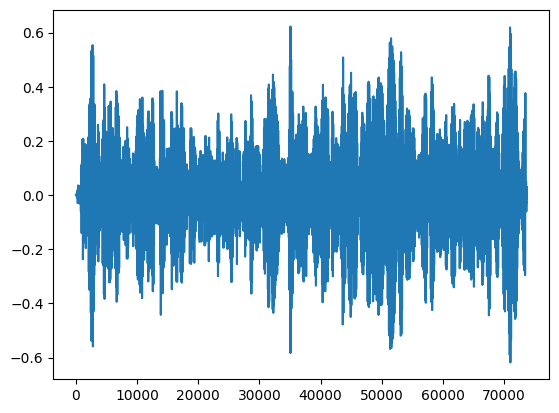

In [11]:
beerocon = model.decode(bee_z)

beereconsignal = beerocon[0,0,:].cpu().detach().numpy()
plt.plot(beereconsignal)
ipd.Audio(beereconsignal, rate=44100)


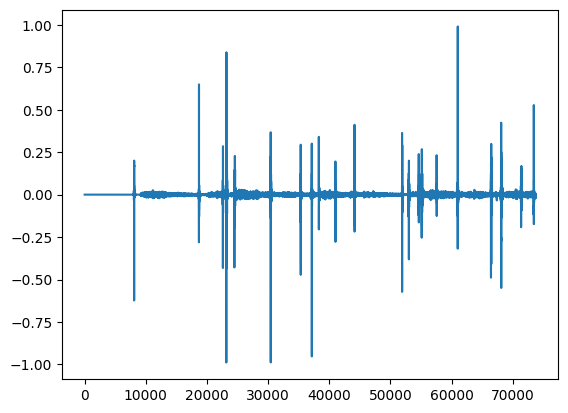

In [12]:
windrocon = model.decode(wind_z)

windreconsignal = windrocon[0,0,:].cpu().detach().numpy()
plt.plot(windreconsignal)
ipd.Audio(windreconsignal, rate=44100)

#original 
#windsignal=wind.audio_data.cpu().detach().numpy()[0,0,:]
#plt.plot(windsignal)
#ipd.Audio(windsignal, rate=44100)

In [13]:
# linear INTERPOLATION between Bee and Wind

MORPHTYPE="FIXED_TWEEN" #"CONTINUOUS_MORPH"
#MORPHTYPE="CONTINUOUS_MORPH"

if MORPHTYPE == "CONTINUOUS_MORPH" :
    timesteps = bee_z.shape[2]  
    # Generate linearly spaced values between 0 and 1
    linear_values = torch.linspace(0, 1, timesteps, device=device)
    # Reshape the linear_values tensor to match the shape of your tensor
    linear_values = linear_values.view(1, 1, timesteps)
    revlinear_values= 1-linear_values
    print(f'CONTINUOUS_MORPH')

else: 
    # Seems these don't have to sum to 1, but distorts if > 2, buzz if too small
    linear_values = .5
    revlinear_values = .5
    print(f'FIXED_TWEEN')
# OR just fixed interp point:


FIXED_TWEEN


shape of mix z is torch.Size([1, 1024, 144])
signal y.shape is torch.Size([1, 1, 73728])


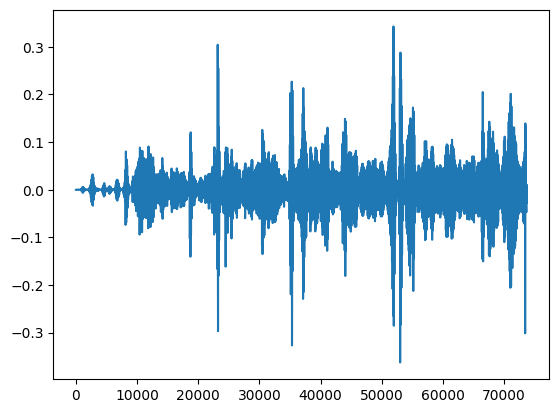

In [14]:
mix_z = linear_values * wind_z + revlinear_values * bee_z
print(f'shape of mix z is {mix_z.shape}')
y = model.decode(mix_z)
print(f'signal y.shape is {y.shape}') 
mix_signal = y[0,0,:].cpu().detach().numpy()
plt.plot(mix_signal)
ipd.Audio(mix_signal, rate=44000)